In [1]:
import pandas as pd
import numpy as np
import time
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import randint, uniform

import sys
sys.path.append('../')
from backtest_functions_v2 import *

In [2]:
# Load the latest dataset
df = pd.read_parquet("../data/full_dataset_feature_engineering_v3.parquet")
print("Dataset loaded successfully.")
df.info()

Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35058 entries, 2021-01-01 06:00:00 to 2024-12-31 23:00:00
Columns: 149 entries, news_count to reddit_average_sentiment_ewm_100h
dtypes: float64(87), int32(1), int64(61)
memory usage: 40.0 MB


### Data Preparation and Splitting

In [3]:
# Manual feature selection

selected_features = [
  'news_count',
  'tanalysis_absa', 'economy_absa', 'regulation_absa', 
  'adoption_absa', 'cybersecurity_absa', 'technology_absa',
  'tanalysis_absa_ewm_100h', 'economy_absa_ewm_100h',
  'regulation_absa_ewm_100h', 'technology_absa_ewm_100h',
  'adoption_absa_ewm_100h', 'cybersecurity_absa_ewm_100h',

  'reddit_total_sentiment_ewm_2h',
  'reddit_average_sentiment_ewm_100h',

  'topic_exchange traded funds, ETF_last3',
  'topic_institutional investments_last3',
  'topic_market sentiment_last3',
  'topic_price action, price movement, trading_last3',

  "source_Coindesk_last3",  
  "source_Cointelegraph_last3",  
  "source_Bitcoin Magazine_last3",  
  "source_Benzinga_last3",  
  "source_The Daily Hodl_last3",  

  "NER_blackrock_last3",  
  "NER_sec_last3",  
  "NER_fed_last3",  
  "NER_grayscale_last3",  
  "NER_binance_last3",  
  "NER_coinbase_last3",  
  "NER_microstrategy_last3",  
  "NER_michael saylor_last3",

  "pct_b_10",
  "sma_20_50_diff",
  "atr_14",
  "atr_ratio",
  "atr_7_chg",
  "20_band_width",
  "rsi_ratio",
  "20_band_width"
]

# Define training (2021-2023) and testing (2024) periods
df_train = df[df['year'].isin([2021, 2022, 2023])]
df_test = df[df['year'] == 2024]

X_train = df_train[selected_features]
y_train = df_train['target']
X_test = df_test[selected_features]
y_test = df_test['target']

# Print shapes and class distribution
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

X_train shape: (26274, 40)
y_train shape: (26274,)
X_test shape: (8784, 40)
y_test shape: (8784,)
Training set class distribution: [ 9993  6038 10243]
Test set class distribution: [2648 3274 2862]


### XGBoost Model with RandomizedSearchCV

In [4]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('model', xgb.XGBClassifier(
    objective='multi:softprob', # Output probabilities for each class
    eval_metric='mlogloss',     # Logloss for multiclass classification
    random_state=42,
    n_jobs=-1
  ))
])

# Parameter distributions for RandomizedSearchCV
param_distributions = {
  'model__n_estimators': randint(100, 500),
  'model__max_depth': randint(3, 10),
  'model__learning_rate': uniform(0.005, 0.2),
  'model__subsample': uniform(0.6, 0.4),
  'model__colsample_bytree': uniform(0.6, 0.4),

  # Regularization parameters:
  'model__gamma': uniform(0, 1),
  'model__reg_alpha': uniform(0, 1), # Continuous distribution for L1 reg
  'model__reg_lambda': uniform(0, 2) # Continuous distribution for L2 reg (starting from 1)
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Compute sample weights for handling class imbalance during fitting
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
fit_params = {'model__sample_weight': sample_weights}

# Initialize RandomizedSearchCV
n_iterations = 200 # Number of parameter settings that are sampled
random_search = RandomizedSearchCV(
  estimator=pipeline,
  param_distributions=param_distributions,
  n_iter=n_iterations,
  cv=tscv,
  scoring='roc_auc_ovr_weighted',
  n_jobs=-1,
  verbose=1,
  random_state=42 # For reproducibility of the search
)

# Fit RandomizedSearchCV on the training data
print(f"Starting RandomizedSearchCV for XGBoostClassifier ({n_iterations} iterations)...")
start_time = time.time()
# Pass fit_params to the fit method
random_search.fit(X_train, y_train, **fit_params)
end_time = time.time()

print(f"\nRandomizedSearchCV fitting time: {end_time - start_time:.2f} seconds")
print("Best parameters found: ")
pprint(random_search.best_params_)
print("\nBest cross-validation ROC AUC score: ", random_search.best_score_)

# Get the best estimator found by RandomizedSearchCV
best_model = random_search.best_estimator_

Starting RandomizedSearchCV for XGBoostClassifier (200 iterations)...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits

RandomizedSearchCV fitting time: 569.82 seconds
Best parameters found: 
{'model__colsample_bytree': 0.7565928440806008,
 'model__gamma': 0.531857479688174,
 'model__learning_rate': 0.018323822478163394,
 'model__max_depth': 5,
 'model__n_estimators': 138,
 'model__reg_alpha': 0.11689804070836407,
 'model__reg_lambda': 1.8796642472269502,
 'model__subsample': 0.851083221228567}

Best cross-validation ROC AUC score:  0.5846195916613584


### Feature Importance Analysis


Top 20 most important features:
                                  Feature  Importance
34                                 atr_14    0.168968
37                          20_band_width    0.069716
39                          20_band_width    0.066650
32                               pct_b_10    0.035021
35                              atr_ratio    0.030720
19                  source_Coindesk_last3    0.028037
20             source_Cointelegraph_last3    0.026772
36                              atr_7_chg    0.026109
21          source_Bitcoin Magazine_last3    0.025198
38                              rsi_ratio    0.024189
11                 adoption_absa_ewm_100h    0.024162
16  topic_institutional investments_last3    0.020999
7                 tanalysis_absa_ewm_100h    0.019450
33                         sma_20_50_diff    0.019398
9                regulation_absa_ewm_100h    0.019335
8                   economy_absa_ewm_100h    0.018908
0                              news_count    0.01

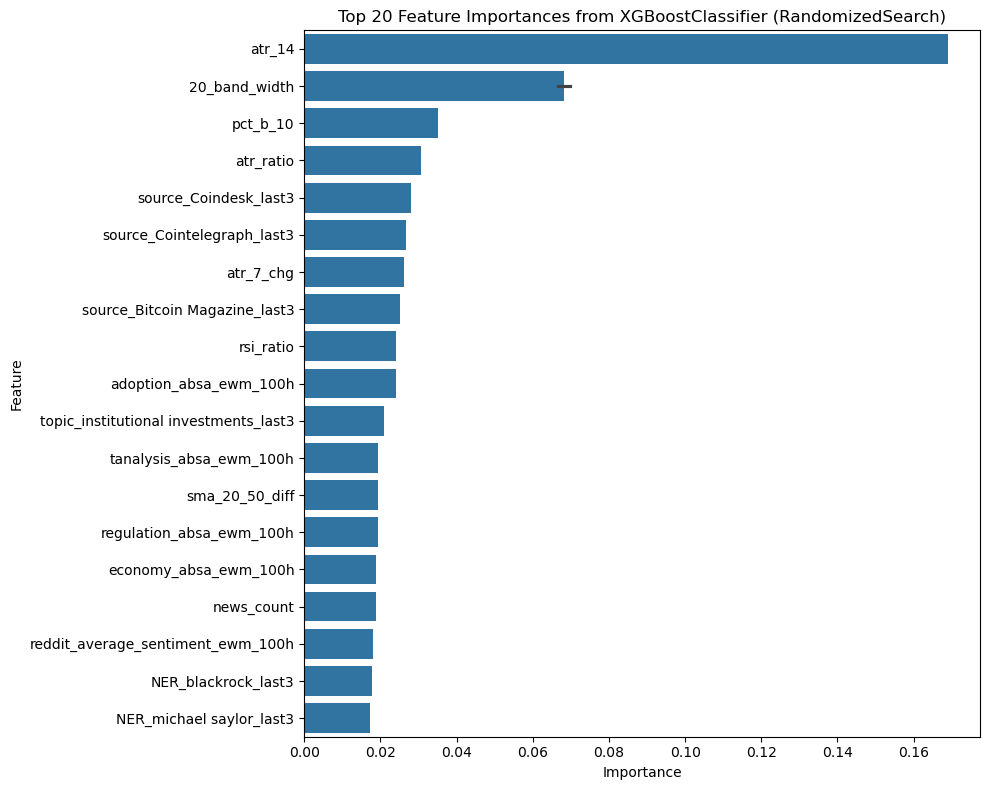

In [5]:
# Get feature importances from the best XGBoost model
importances = best_model.named_steps['model'].feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nTop 20 most important features:")
print(importance_df.head(20))

# Plot top 20 feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances from XGBoostClassifier (RandomizedSearch)')
plt.tight_layout()
plt.show()

### Model Evaluation on Test Set


Predicting on the test set...
Prediction complete.

Test Set Evaluation:
Accuracy: 0.4958
ROC AUC Score (One-vs-Rest): 0.6923

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.41      0.42      0.41      2648
 Neutral (1)       0.73      0.50      0.60      3274
 Bullish (2)       0.42      0.55      0.48      2862

    accuracy                           0.50      8784
   macro avg       0.52      0.49      0.50      8784
weighted avg       0.53      0.50      0.50      8784


Confusion Matrix:
[[1116  283 1249]
 [ 680 1651  943]
 [ 943  331 1588]]


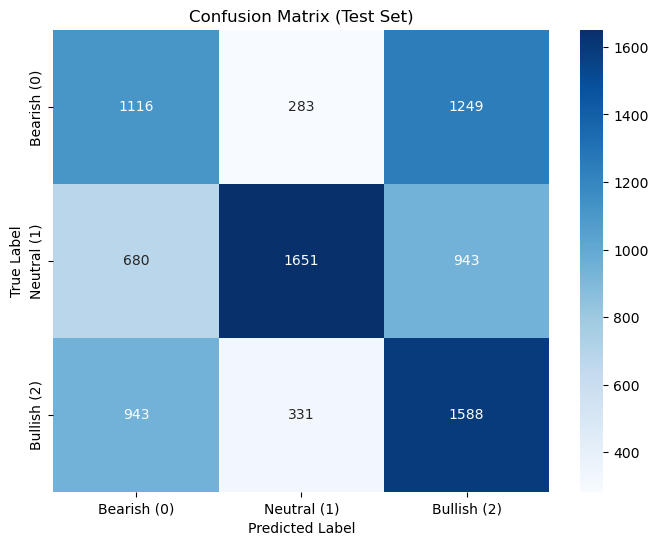

In [6]:
# Make predictions on the test set
print("\nPredicting on the test set...")
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)
print("Prediction complete.")

# Evaluate the model performance on the test set
accuracy = accuracy_score(y_test, y_pred)
class_names = ['Bearish (0)', 'Neutral (1)', 'Bullish (2)']
report = classification_report(y_test, y_pred, target_names=class_names)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"\nTest Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score (One-vs-Rest): {roc_auc:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

### Monthly Accuracy Analysis


Monthly Accuracy (2024 Test Set):
2024-01-31    0.424731
2024-02-29    0.449713
2024-03-31    0.452957
2024-04-30    0.438889
2024-05-31    0.434140
2024-06-30    0.438889
2024-07-31    0.397849
2024-08-31    0.427419
2024-09-30    0.550000
2024-10-31    0.729839
2024-11-30    0.616667
2024-12-31    0.587366
Freq: ME, Name: correct_prediction, dtype: float64


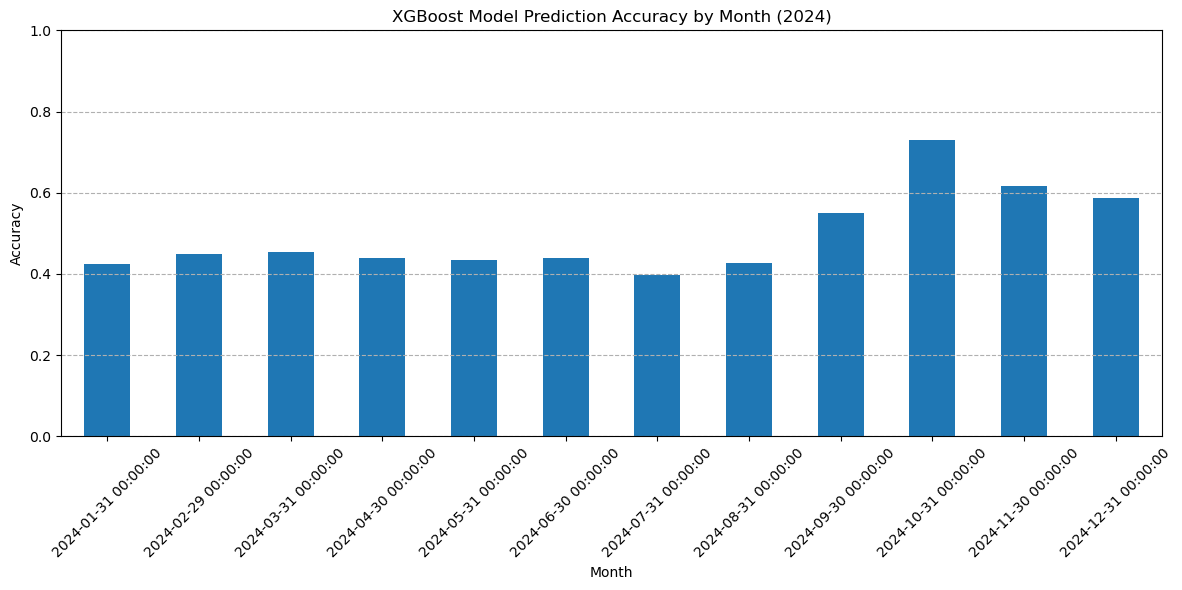


Sample of Test Results with Predictions:
                     target  predicted_class actual_label predicted_label  \
2024-01-01 00:00:00       0                1      Bearish         Neutral   
2024-01-01 01:00:00       1                1      Neutral         Neutral   
2024-01-01 02:00:00       0                1      Bearish         Neutral   
2024-01-01 03:00:00       1                2      Neutral         Bullish   
2024-01-01 04:00:00       2                2      Bullish         Bullish   

                     prob_bearish  prob_neutral  prob_bullish  
2024-01-01 00:00:00      0.337885      0.414708      0.247407  
2024-01-01 01:00:00      0.289888      0.426023      0.284089  
2024-01-01 02:00:00      0.264748      0.453670      0.281582  
2024-01-01 03:00:00      0.301576      0.276921      0.421503  
2024-01-01 04:00:00      0.282927      0.302406      0.414667  


In [7]:
# Add predictions and probabilities to the test dataframe for analysis
df_test_results = df_test.copy()

df_test_results.loc[:, 'predicted_class'] = y_pred
df_test_results.loc[:, 'prob_bearish'] = y_pred_proba[:, 0]
df_test_results.loc[:, 'prob_neutral'] = y_pred_proba[:, 1]
df_test_results.loc[:, 'prob_bullish'] = y_pred_proba[:, 2]

# Map numerical target/prediction to labels for clarity
target_map = {0: 'Bearish', 1: 'Neutral', 2: 'Bullish'}
df_test_results.loc[:, 'actual_label'] = df_test_results['target'].map(target_map)
df_test_results.loc[:, 'predicted_label'] = df_test_results['predicted_class'].map(target_map)

# Calculate if the prediction was correct
df_test_results.loc[:, 'correct_prediction'] = (df_test_results['target'] == df_test_results['predicted_class']).astype(int)

# --- Monthly Accuracy Analysis ---
if isinstance(df_test_results.index, pd.DatetimeIndex):
    # Ensure the index is timezone-naive or handle conversion if necessary
    if df_test_results.index.tz is not None:
        df_test_results.index = df_test_results.index.tz_localize(None)
        
    monthly_accuracy = df_test_results.resample('ME')['correct_prediction'].mean()
    
    print("\nMonthly Accuracy (2024 Test Set):")
    print(monthly_accuracy)
    
    plt.figure(figsize=(12, 6))
    monthly_accuracy.plot(kind='bar')
    plt.title('XGBoost Model Prediction Accuracy by Month (2024)')
    plt.ylabel('Accuracy')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    plt.ylim(0, 1) # Set y-axis limits for better comparison
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print("Index is not DatetimeIndex. Skipping monthly accuracy plot.")

# Display some results
print("\nSample of Test Results with Predictions:")
print(df_test_results[['target', 'predicted_class', 'actual_label', 'predicted_label', 'prob_bearish', 'prob_neutral', 'prob_bullish']].head())

### Backtesting the Strategy

Sample signals for backtesting:
                     target  predicted_class  signal
2024-01-01 00:00:00       0                1       0
2024-01-01 01:00:00       1                1       0
2024-01-01 02:00:00       0                1       0
2024-01-01 03:00:00       1                2       1
2024-01-01 04:00:00       2                2       1

Predicted signal distribution for backtest:
signal
 1    3780
-1    2739
 0    2265
Name: count, dtype: int64
Overall Annual Return: 167.87%
Overall Annual Sharpe Ratio: 2.2603
Maximum Drawdown: -22.21 %
Alpha: 1.3712
Beta: 0.2595

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       1.678656    0.488871     0.259498      0.863441       2.260322


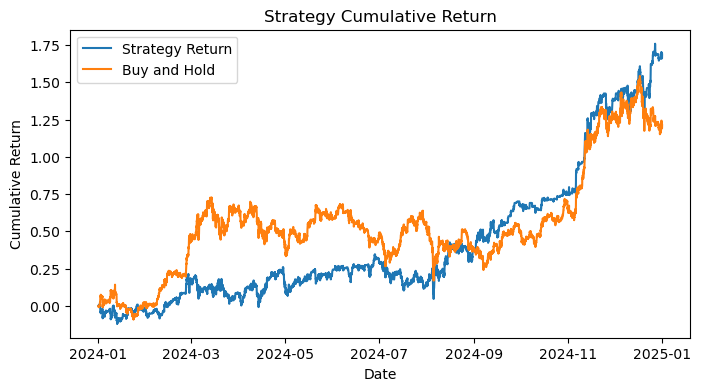

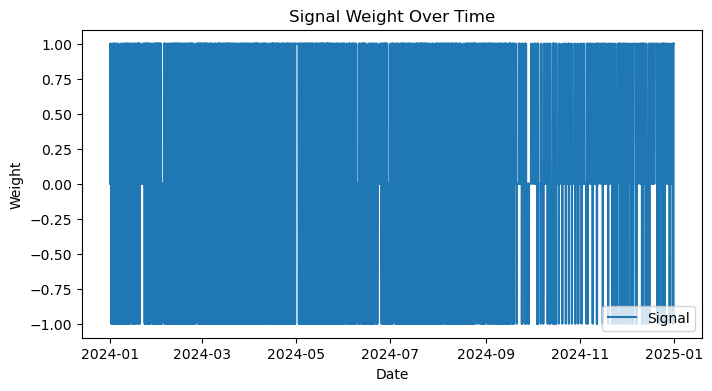

In [8]:
# Prepare dataframe for backtesting
df_backtest = df_test_results.copy()

# Map predicted class to trading signal: 0 -> -1 (Short), 1 -> 0 (Neutral), 2 -> 1 (Long)
df_backtest['signal'] = df_backtest['predicted_class'] - 1

# Display the first few rows with the new signal column
print("Sample signals for backtesting:")
print(df_backtest[['target', 'predicted_class', 'signal']].head())

# Check the distribution of the generated signals
print("\nPredicted signal distribution for backtest:")
print(df_backtest['signal'].value_counts())


run_backtest(df_backtest, freq='h')